# Elman_network.ipynb

Using an Elman network to learn to trace circles and figure eights.

In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import lovely_tensors as lt
lt.monkey_patch()
%cd ./data/

/home/z/Dropbox (OIST)/code/python/pytorch/rnn_tasks/data


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cuda:0


In [3]:
# Load training data
fname = 'circle10_1.pkl'
with open(fname, 'rb') as f:
    coordinates = pickle.load(f)

Coordinates shape: torch.Size([882, 2])


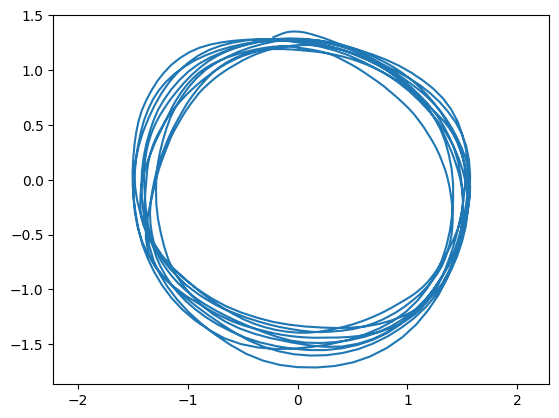

In [4]:
# plot the loaded array
fig = plt.figure()
plt.axis('equal')
plt.plot(coordinates[:,0], coordinates[:,1])

coordinates = torch.tensor(coordinates, dtype=torch.float32)
print(f"Coordinates shape: {coordinates.shape}")

In [5]:
# Create the network, the optimizer, and the loss function
input_size = 2  # this shouldn't change
hidden_size = 50
nonlinearity = 'tanh'  # tanh or relu
lr = 3e-4  # learning rate
all_generated = []

torch.manual_seed(345)

class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, nonlinearity):
        super(ElmanRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.nonlinearity = nonlinearity
        self.rnn = nn.RNN(input_size=input_size,
                          hidden_size=hidden_size,
                          nonlinearity=nonlinearity,
                          num_layers=1,
                          batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 =  torch.zeros((1, hidden_size))
        out, h = self.rnn(x, h0)
        return self.fc(out), h

ernn = ElmanRNN(input_size, hidden_size, nonlinearity)

optim = torch.optim.Adam(ernn.parameters(), lr=lr)

loss = nn.MSELoss(reduction='mean')

In [6]:
# training loop
n_epochs = 300  # number of epochs

for epoch in range(n_epochs):
    optim.zero_grad()
    out, _  = ernn(coordinates[:-1])
    error = loss(out, coordinates[1:])
    error.backward()
    optim.step()
    if (epoch + 1) % 20 == 0:
        print(f"Error at epoch {epoch} = {error}")

Error at epoch 19 = 0.6982629299163818
Error at epoch 39 = 0.40435341000556946
Error at epoch 59 = 0.09367822110652924
Error at epoch 79 = 0.026275409385561943
Error at epoch 99 = 0.018242286518216133
Error at epoch 119 = 0.015431366860866547
Error at epoch 139 = 0.013269055634737015
Error at epoch 159 = 0.011689978651702404
Error at epoch 179 = 0.010457375086843967
Error at epoch 199 = 0.00946035049855709
Error at epoch 219 = 0.008634326048195362
Error at epoch 239 = 0.007934913039207458
Error at epoch 259 = 0.007332234177738428
Error at epoch 279 = 0.006805588956922293
Error at epoch 299 = 0.006340428255498409


In [10]:
# Generate a trajectory
n_points = 1000
coordinate = torch.tensor([-1, 1], dtype=torch.float32)
#coordinate = coordinates[0]
coordinate = coordinate.unsqueeze(dim=0)

def generate_trajectory(init_coordinate, n_points):
    gen_coordinates = np.empty((n_points, 2))
    coordinate = init_coordinate
    h = torch.zeros((1, hidden_size))
    with torch.no_grad():
        for point_idx in range(n_points):
            coordinate, h = ernn(coordinate, h)
            gen_coordinates[point_idx, :] = coordinate.detach().numpy()
    return gen_coordinates

gen_coordinates = generate_trajectory(coordinate, n_points)
all_generated.append(gen_coordinates)

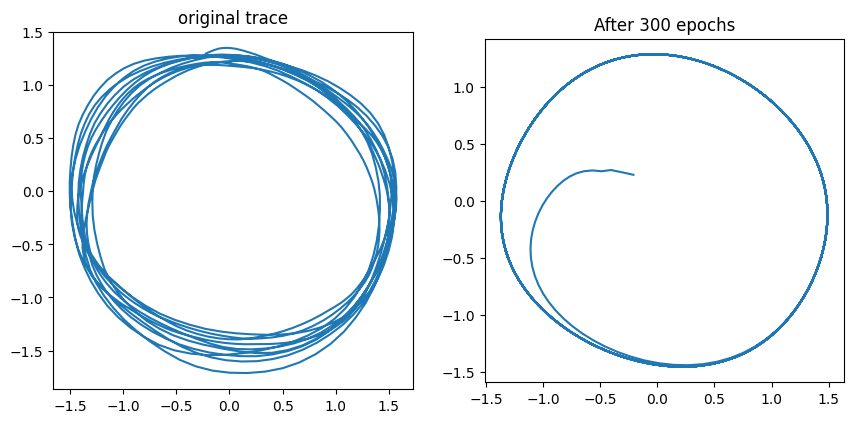

In [15]:
n_traces = len(all_generated)

if n_traces > 3:
    n_rows = int(np.floor(np.sqrt(n_traces + 1)))
    n_cols = int(np.ceil((n_traces+1) / n_rows))
else:
    n_cols = n_traces + 1 
    n_rows = 1
fig, axs = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(5.1*n_cols,5.1*n_rows))
for ax in axs:
    if type(ax) == np.ndarray:
        for _ax in ax:
            _ax.set_aspect('equal')
    else:
        ax.set_aspect('equal')
original = coordinates.cpu().detach()
if n_rows > 1:
    ax0 = axs[0,0]
else:
    ax0 = axs[0]
ax0.plot(original[:,0], original[:,1])
ax0.set_title('original trace')
for trace in range(n_traces):
    gen_coordinates = all_generated[trace]
    if n_rows == 1:
        ax = axs[trace+1]
    else:
        row = int(np.floor((trace+1)/n_cols))
        col = int(np.ceil((trace+1)%n_cols)) 
        ax = axs[row, col]
    ax.set_title(f'After {n_epochs*(trace+1)} epochs')
    ax.plot(gen_coordinates[:,0], gen_coordinates[:,1])

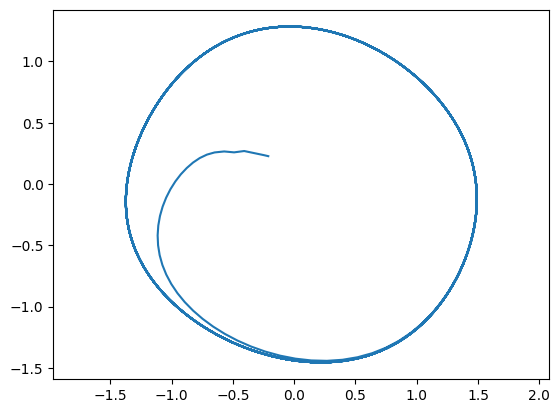

In [11]:
# plot the generated trajectory
fig = plt.figure()
plt.axis('equal')
plt.plot(gen_coordinates[:,0], gen_coordinates[:,1])

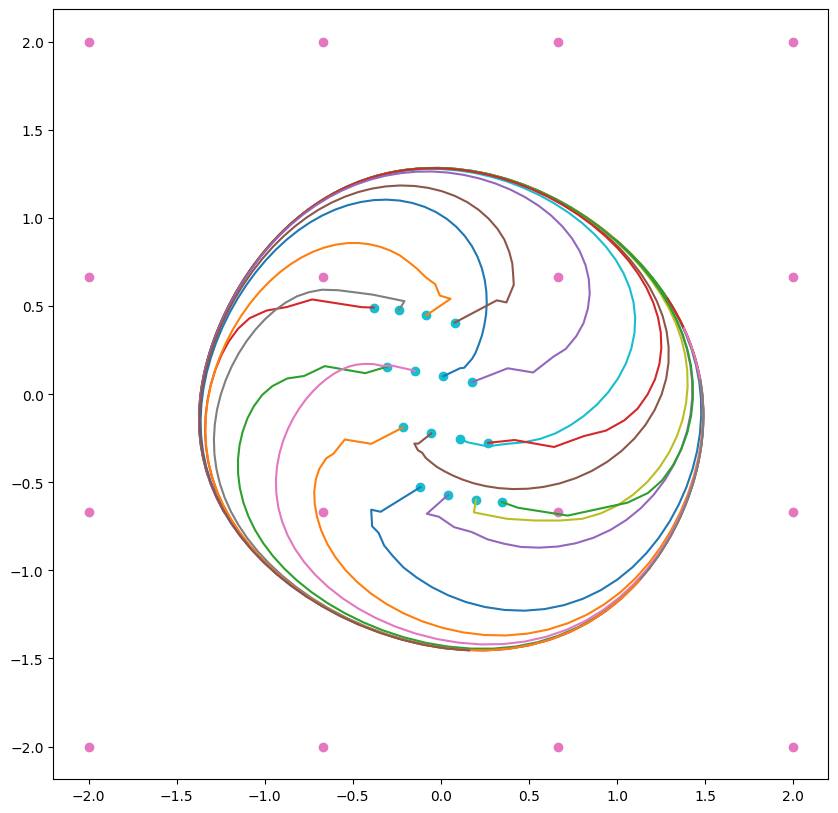

In [12]:
# plot a direction field
lim_x = 2. # largest magnitude of x
lim_y = 2.
N_x = 4 # number of points in x dimension
N_y = 4
n_points = 60
#df_fig = plt.figure(figsize = (10,10))
fig = plt.figure(figsize=(10,10))
plt.xlim(-1.1*lim_x, 1.1*lim_x)
plt.ylim(-1.1*lim_y, 1.1*lim_y)
plt.axis('equal')
for x in np.linspace(-lim_x, lim_x, N_x):
    for y in np.linspace(-lim_y, lim_y, N_y):
        #print(f"x = {x}, y = {y}")
        plt.scatter([x], [y], color='tab:pink')
        coordinate = torch.tensor([x, y], dtype=torch.float32).unsqueeze(dim=0)
        trajectory = generate_trajectory(coordinate, n_points)
        plt.scatter([trajectory[0, 0]], [trajectory[0,1]], color='tab:cyan')
        plt.plot(trajectory[:, 0], trajectory[:, 1])
plt.show()